In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
import pickle

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [2]:
without_transfer = df.loc[df.type_of_transfer == 'No transfer']
def apply_accuracy_without_transfer(x):
    queried = without_transfer.query('source_device_name == "{}" & source_dataset == "{}" & features == "{}" & label == "{}" & classifier == "{}"'.format(
        x['source_device_name'],
        x['source_dataset'],
        x['features'],
        x['label'],
        x['classifier']
    ))

    if len(queried) > 0:
        return queried['accuracy_positive'].iloc[0]

    return -1

In [3]:
def to_accuracy_bin(acc):
    bins = [
        [0.0, 0.5],
        [0.5, 0.75],
        [0.75, 1.0]
    ]
    return [i for i, b in enumerate(bins) if b[0] <= acc and b[1] >= acc][0]

df['accuracy_bin'] = [to_accuracy_bin(a) for a in df['accuracy_positive']]
filtered = df.loc[df.accuracy_negative >= 0.95]
filtered = filtered.loc[filtered.type_of_transfer != 'No transfer']
filtered = filtered.loc[filtered.type_of_transfer != 'Across spaces']
filtered['accuracy_without_transfer'] = filtered.apply(apply_accuracy_without_transfer, axis=1)

msk = np.random.rand(len(filtered)) <= 0.5
train = filtered[msk]
test = filtered[~msk]

def to_x_and_y(filtered):

    X = filtered[[
        'features',
        'classifier',
        'label',
        'type_of_transfer',
        'accuracy_without_transfer',
        'accuracy_negative'
    ]]

    y = filtered['accuracy_bin']

    X = [dict(r.iteritems()) for _, r in X.iterrows()]
    y = y.values
    
    return X, y

X_train, y_train = to_x_and_y(train)
X_test, y_test = to_x_and_y(test)

ppl = Pipeline([
    ('vect', DictVectorizer()),
    ('impute', Imputer()),
    ('clf', RandomForestClassifier())
])

ppl.fit(X_train, y_train)
predicted = ppl.predict(X_test)
accuracy_score(y_test, predicted)

0.85567451820128482

In [4]:
predictions = pd.Series(predicted)
predictions.index = test.index
df['predictions'] = predictions

df_tested = df.loc[df.predictions >= 0]
counts = df_tested[['accuracy_bin', 'predictions']].groupby(['accuracy_bin', 'predictions']).size()
counts = pd.DataFrame(counts)
counts.columns = ['count']
counts.pivot_table(index=['accuracy_bin'], columns=['predictions'], values=['count'])

count         
predictions    0.0 1.0  2.0
accuracy_bin               
0             1817  30   39
1               98  17   38
2              111  21  164

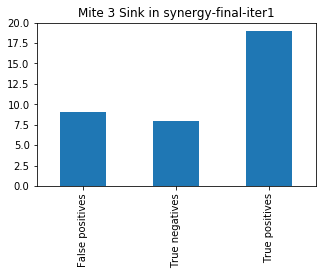

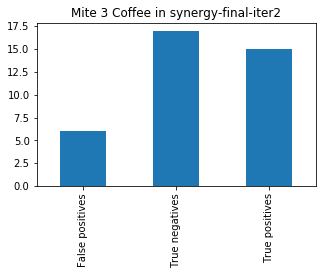

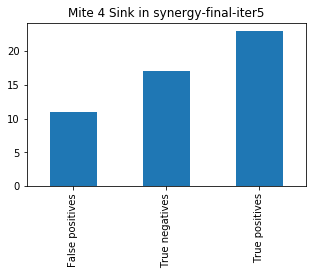

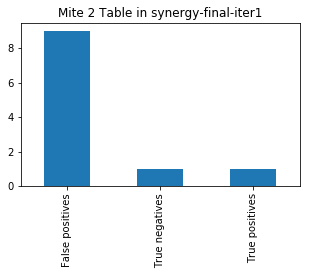

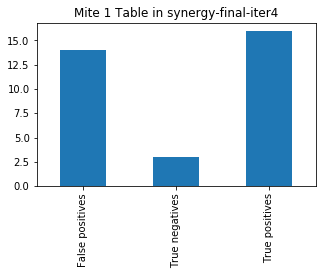

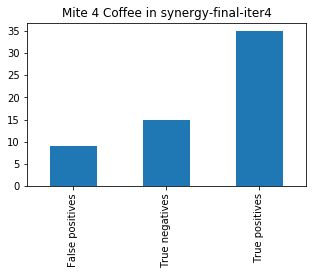

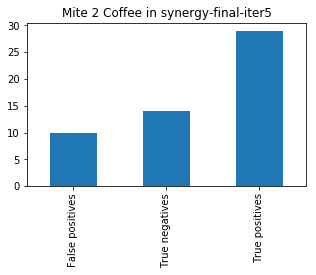

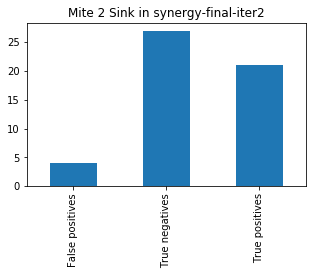

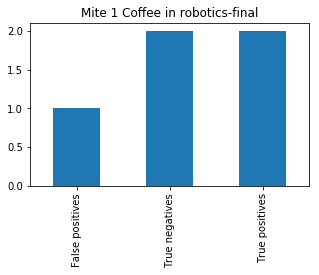

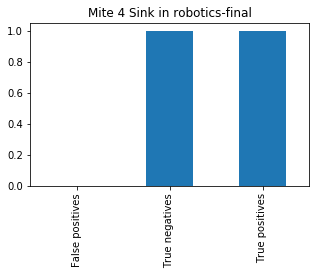

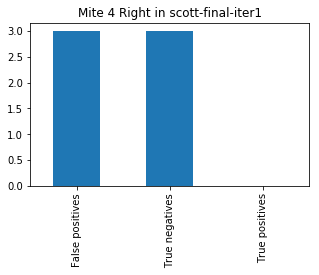

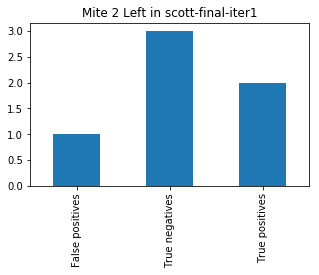

In [5]:
cases = df_tested[['target_device_name', 'target_dataset']].drop_duplicates()
plt.rcParams["figure.figsize"] = (5, 3)

for _, case in cases.iterrows():
    device_name = case['target_device_name']
    dataset = case['target_dataset']
    df_relevant = df_tested.loc[df_tested.target_device_name == device_name]
    df_relevant = df_relevant.loc[df_relevant.target_dataset == dataset]

    good_models = df_relevant.loc[df_relevant.accuracy_bin == 2]
    predicted_models = df_relevant.loc[df_relevant.predictions == 2]
    
    true_positives = good_models.loc[good_models.predictions == 2]
    false_positives = predicted_models.loc[predicted_models.accuracy_bin != 2]
    true_negatives = good_models.loc[good_models.predictions == 0]

    pd.Series({
        'True positives': len(true_positives),
        'False positives': len(false_positives),
        'True negatives': len(true_negatives),
    }).plot.bar()
    plt.title(device_name + ' in ' + dataset)
    plt.show()

synergy-final-iter1 Mite 3 Sink


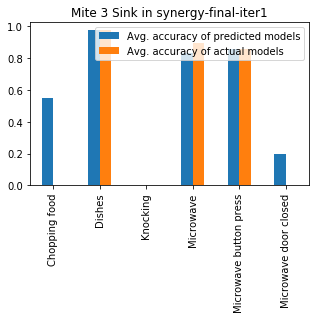

synergy-final-iter2 Mite 3 Coffee


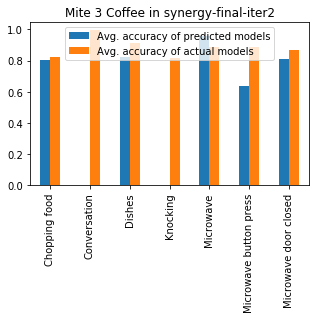

synergy-final-iter5 Mite 4 Sink


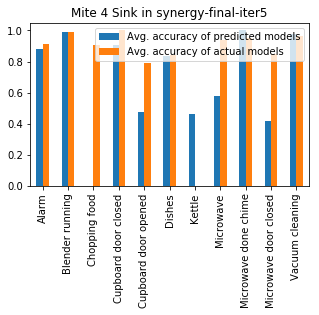

synergy-final-iter1 Mite 2 Table


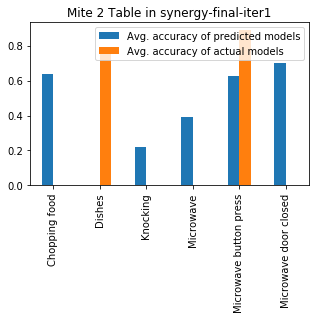

synergy-final-iter4 Mite 1 Table


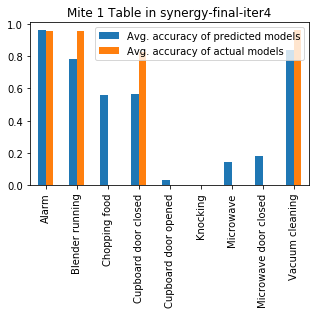

synergy-final-iter4 Mite 4 Coffee


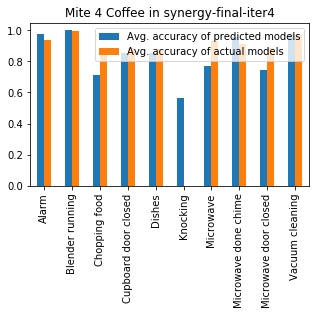

synergy-final-iter5 Mite 2 Coffee


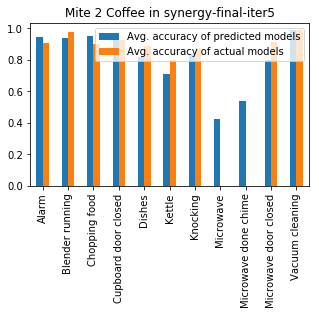

synergy-final-iter2 Mite 2 Sink


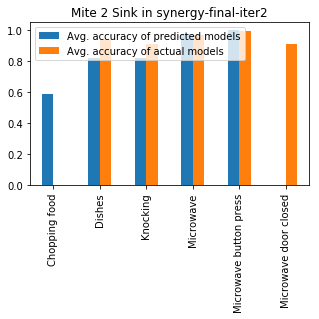

robotics-final Mite 1 Coffee


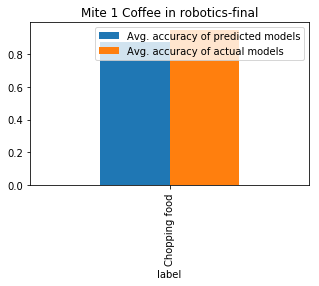

robotics-final Mite 4 Sink


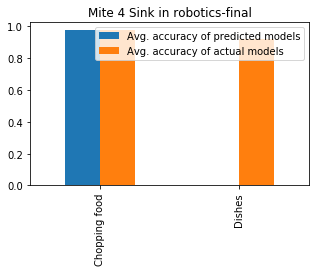

scott-final-iter1 Mite 4 Right


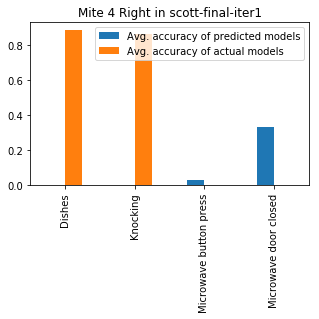

scott-final-iter1 Mite 2 Left


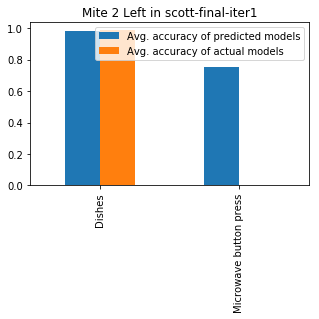

In [7]:
### plt.rcParams["figure.figsize"] = (7, 5)

for _, case in cases.iterrows():
    device_name = case['target_device_name']
    dataset = case['target_dataset']
    print(dataset, device_name)
    df_relevant = df_tested.loc[df_tested.target_device_name == device_name]
    df_relevant = df_relevant.loc[df_relevant.target_dataset == dataset]

    good_models = df_relevant.loc[df_relevant.accuracy_bin == 2]
    predicted_models = df_relevant.loc[df_relevant.predictions == 2]

    predicted_models = predicted_models[['label', 'accuracy_positive']]
    predicted_models = predicted_models.rename(columns={'accuracy_positive': 'Avg. accuracy of predicted models'})
    predicted_models = predicted_models.groupby(['label'])['Avg. accuracy of predicted models'].mean()

    good_models = good_models[['label', 'accuracy_positive']]
    good_models = good_models.rename(columns={'accuracy_positive': 'Avg. accuracy of actual models'})
    good_models = good_models.groupby(['label'])['Avg. accuracy of actual models'].mean()

    pd.concat([predicted_models, good_models], axis=1).plot.bar()

    plt.title(device_name + ' in ' + dataset)
    plt.show()

In [27]:
import pickle

class TransferableModelsForCase:
    def __init__(self, target_device_name, target_dataset):
        self.target_device_name = target_device_name
        self.target_dataset = target_dataset
        self.transferable_models = []
        
    def add_transferable_model(self, source_dataset, source_device_name, label,
                               classifier, features,
                               accuracy_positive, accuracy_negative):
        self.transferable_models.append({
            "source_dataset": source_dataset,
            "source_device_name": source_device_name,
            "label": label,
            "classifier": classifier,
            "features": features,
            "accuracy_positive": accuracy_positive,
            "accuracy_negative": accuracy_negative
        })

transferable_models = []
for _, case in cases.iterrows():
    device_name = case['target_device_name']
    dataset = case['target_dataset']
    
    models_for_case = TransferableModelsForCase(target_device_name=device_name,
                                               target_dataset=dataset)
    
    print(dataset, device_name)
    df_relevant = df_tested.loc[df_tested.target_device_name == device_name]
    df_relevant = df_relevant.loc[df_relevant.target_dataset == dataset]

    predicted_models = df_relevant.loc[df_relevant.predictions == 2]
    for i, row in predicted_models.iterrows():
        models_for_case.add_transferable_model(source_dataset=row['source_dataset'],
                                               source_device_name=row['source_device_name'],
                                               classifier=row['classifier'],
                                               label=row['label'],
                                               features=row['features'],
                                               accuracy_positive=row['accuracy_positive'],
                                               accuracy_negative=row['accuracy_negative'])
    transferable_models.append(models_for_case)

output = open('transferable_models.p', 'wb')
pickle.dump(transferable_models, output)
output.close()

synergy-final-iter1 Mite 3 Sink
synergy-final-iter2 Mite 3 Coffee
synergy-final-iter5 Mite 4 Sink
synergy-final-iter1 Mite 2 Table
synergy-final-iter4 Mite 1 Table
synergy-final-iter4 Mite 4 Coffee
synergy-final-iter5 Mite 2 Coffee
synergy-final-iter2 Mite 2 Sink
robotics-final Mite 1 Coffee
robotics-final Mite 4 Sink
scott-final-iter1 Mite 4 Right
scott-final-iter1 Mite 2 Left


In [16]:
list(df_relevant.loc[df_relevant.predictions == 2].iterrows())[0][1]

source_dataset                          scott-final-iter1
target_dataset                          scott-final-iter1
source_device                                      Mite 4
target_device                                      Mite 2
source_device_name                           Mite 4 Right
target_device_name                            Mite 2 Left
source_room                                         scott
target_room                                         scott
source_placement                                    Right
target_placement                                     Left
type_of_transfer      Same device type in different place
classifier                                            SVM
label                                              Dishes
features                                              All
accuracy                                         0.993905
accuracy_positive                                0.958678
accuracy_negative                                       1
accuracy_bin  

In [8]:
for _, case in cases.iterrows():
    device_name = case['target_device_name']
    dataset = case['target_dataset']
    print(dataset, device_name)
    df_relevant = df_tested.loc[df_tested.target_device_name == device_name]
    df_relevant = df_relevant.loc[df_relevant.target_dataset == dataset]
    
    print(df_relevant.loc[df_relevant.accuracy_bin == 2][['source_dataset', 'source_device', 'label']].drop_duplicates())
    print(df_relevant.loc[df_relevant.predictions == 2][['source_dataset', 'source_device', 'label']].drop_duplicates())
    
    print('Options', len(df_relevant))
    print('Good options', len(df_relevant.loc[df_relevant.accuracy_bin == 2]))
    print('Good option labels', len(df_relevant.loc[df_relevant.accuracy_bin == 2].label.unique()))
    print(df_relevant.loc[df_relevant.accuracy_bin == 2].label.unique())
    print('Predicted options', len(df_relevant.loc[df_relevant.predictions == 2]))
    print('Predicted option labels', len(df_relevant.loc[df_relevant.predictions == 2].label.unique()))
    print()

synergy-final-iter1 Mite 3 Sink
            source_dataset source_device                   label
181    synergy-final-iter2        Mite 2               Microwave
901    synergy-final-iter2        Mite 2                  Dishes
1381   synergy-final-iter2        Mite 2  Microwave button press
1908   synergy-final-iter2        Mite 3               Microwave
2748   synergy-final-iter2        Mite 3                  Dishes
3058   synergy-final-iter2        Mite 3  Microwave button press
6607   synergy-final-iter5        Mite 2               Microwave
8125   synergy-final-iter5        Mite 4               Microwave
13003  synergy-final-iter1        Mite 2               Microwave
13747  synergy-final-iter1        Mite 2                  Dishes
14203  synergy-final-iter1        Mite 2  Microwave button press
            source_dataset source_device                   label
217    synergy-final-iter2        Mite 2               Microwave
901    synergy-final-iter2        Mite 2                  

actual,0,1,2
predicted,,,
0,553,25,32
1,40,14,12
2,20,17,63


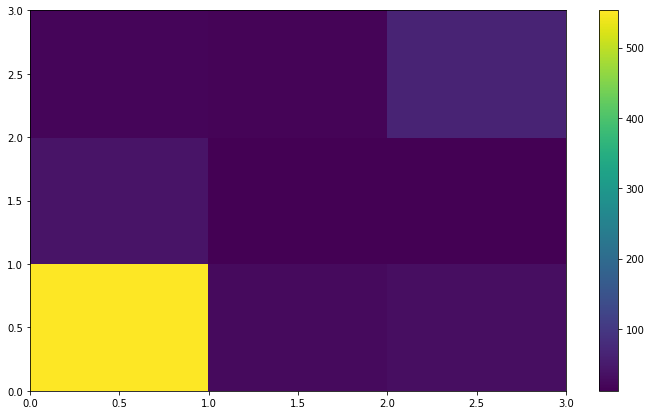

In [16]:
df = pd.DataFrame({'predicted': predicted, 'actual': y_test})
pivoted = df.pivot_table(index='predicted', columns='actual', aggfunc=len, fill_value=0)
plt.pcolor(pivoted)
plt.colorbar()
pivoted

In [9]:
from IPython.display import Image
import pydotplus

clf = ppl.named_steps['clf']

dot_data = tree.export_graphviz(clf, out_file=None,
#                                 feature_names=iris.feature_names,
#                                 class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("decision_tree.pdf")

True